In [ ]:
!pip install cufflinks

In [2]:
# --- Step 1: import libraries ---
import pandas as pd
import numpy as np
import cufflinks
import matplotlib.pyplot as plt
from math import log

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Step 2: get file paths ---
import os
WT_ISO_VS_WT_0 = "/content/drive/MyDrive/Colab Notebooks/CW_App_BI/WT_iso_vs_WT_0/gene_exp.diff"
GLN3_ISO_VS_WT_ISO = "/content/drive/MyDrive/Colab Notebooks/CW_App_BI/gln3_iso_vs_WT_iso/gene_exp.diff"

GENESET_DIR = "/content/drive/MyDrive/Colab Notebooks/CW_App_BI/gene_sets"


GENESET_FILES = {
    "amino_acid": os.path.join(GENESET_DIR, "genes_amino_acid_biosynthesis_clean.txt"),
    "glycolysis": os.path.join(GENESET_DIR, "genes_glycolysis_clean.txt"),
    "cell_wall": os.path.join(GENESET_DIR, "genes_cell_wall_clean.txt"),
    "lipid": os.path.join(GENESET_DIR, "genes_lipid_biosynthesis_clean.txt"),
}

In [5]:
# --- Step 3: load cuffdiff output ---
def load_gene_exp_diff(path):
    df = pd.read_csv(path, sep="\t")
    # enforce expected column names (cuffdiff standard)
    expected = ["test_id","gene_id","gene","locus","sample_1","sample_2","status",
                "value_1","value_2","log2(fold_change)","test_stat","p_value","q_value","significant"]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns in {path}: {missing}\nFound columns:\n{list(df.columns)}")
    return df

WT_ISO_VS_WT_0_DF = load_gene_exp_diff(WT_ISO_VS_WT_0)
GLN3_ISO_VS_WT_ISO_DF = load_gene_exp_diff(GLN3_ISO_VS_WT_ISO)

display(WT_ISO_VS_WT_0_DF.head(3))
display(GLN3_ISO_VS_WT_ISO_DF.head(3))

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
0,15S_rRNA,15S_rRNA,15S_RRNA,ref|NC_001224|:6545-8194,WT_iso,WT_0,OK,4736.07,2514.62,-0.913352,-0.225650,0.45185,0.736443,no
1,21S_rRNA,21S_rRNA,21S_RRNA,ref|NC_001224|:58008-62447,WT_iso,WT_0,OK,1119.66,759.47,-0.559993,-0.529388,0.43820,0.729699,no
2,ETS1-1,ETS1-1,ETS1-1,ref|NC_001144|:457732-458432,WT_iso,WT_0,NOTEST,0.00,0.00,0.000000,0.000000,1.00000,1.000000,no


,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
0,15S_rRNA,15S_rRNA,15S_RRNA,ref|NC_001224|:6545-8194,gln3_iso,WT_iso,OK,1224.960,4137.680,1.75609,0.166908,0.1466,0.800937,no
1,21S_rRNA,21S_rRNA,21S_RRNA,ref|NC_001224|:58008-62447,gln3_iso,WT_iso,OK,341.392,979.776,1.52102,0.181511,0.1799,0.822400,no
2,ETS1-1,ETS1-1,ETS1-1,ref|NC_001144|:457732-458432,gln3_iso,WT_iso,NOTEST,0.000,0.000,0.00000,0.000000,1.0000,1.000000,no


In [14]:
# --- Step 4: confirm sample order and log2FC meaning ---

def check_sample_order(df, label):
    s1 = df.loc[0, "sample_1"]
    s2 = df.loc[0, "sample_2"]
    print(f"{label}")
    print(f"  sample_1 = {s1}")
    print(f"  sample_2 = {s2}")
    print("  cuffdiff log2FC = log2(value_2 / value_1)")
    print()

check_sample_order(WT_ISO_VS_WT_0_DF, "WT_iso_vs_WT_0")
check_sample_order(GLN3_ISO_VS_WT_ISO_DF, "gln3_iso_vs_WT_iso")


WT_iso_vs_WT_0
  sample_1 = WT_iso
  sample_2 = WT_0
  cuffdiff log2FC = log2(value_2 / value_1)

gln3_iso_vs_WT_iso
  sample_1 = gln3_iso
  sample_2 = WT_iso
  cuffdiff log2FC = log2(value_2 / value_1)



In [15]:
# --- Step 5: define DEGs according to paper criteria ---

def apply_paper_deg_criteria(df):
    out = df.copy()

    # Keep only genes that were tested
    out = out[out["status"] == "OK"].copy()

    # Apply paper DEG definition
    out["deg_paper_criteria"] = (
        (out["p_value"] < 0.05) &
        (out["log2(fold_change)"].abs() > 1)
    )

    return out


# Apply to both comparisons
wt_iso_vs_wt_0_deg = apply_paper_deg_criteria(WT_ISO_VS_WT_0_DF)
gln3_iso_vs_wt_iso_deg = apply_paper_deg_criteria(GLN3_ISO_VS_WT_ISO_DF)

# Quick sanity check
print("WT_iso_vs_WT_0")
print(wt_iso_vs_wt_0_deg["deg_paper_criteria"].value_counts())
print()

print("gln3_iso_vs_WT_iso")
print(gln3_iso_vs_wt_iso_deg["deg_paper_criteria"].value_counts())


WT_iso_vs_WT_0
deg_paper_criteria
False    2839
True      613
Name: count, dtype: int64

gln3_iso_vs_WT_iso
deg_paper_criteria
False    2918
True      218
Name: count, dtype: int64


In [16]:
# --- Step 6A: load gene sets (one gene per line) ---
#Reads each gene list file
#Removes blank lines
#Stores genes as Python sets (fast membership lookup)
#Prints how many unique genes are there per pathway

def load_geneset(path):
    genes = []
    with open(path, "r") as f:
        for line in f:
            g = line.strip()
            if not g:
                continue
            genes.append(g)
    # Use a set for fast membership checking
    return set(genes)

gene_sets = {name: load_geneset(path) for name, path in GENESET_FILES.items()}

for name, gset in gene_sets.items():
    print(f"{name}: {len(gset)} genes (unique)")


amino_acid: 91 genes (unique)
glycolysis: 24 genes (unique)
cell_wall: 99 genes (unique)
lipid: 10 genes (unique)


In [17]:
# --- Cell 6B: assign pathway labels to each gene ---

def annotate_pathways(df, gene_sets):
    out = df.copy()

    # A single "primary" pathway label (first match) (useful for coloring)
    # And a "pathways" column listing ALL matches (useful for debugging overlap)
    def get_all_pathways(gene):
        hits = [name for name, gset in gene_sets.items() if gene in gset]
        return hits

    out["pathways"] = out["gene"].apply(get_all_pathways)
    out["pathway_primary"] = out["pathways"].apply(lambda x: x[0] if len(x) > 0 else "none")

    return out

wt_iso_vs_wt_0_annot = annotate_pathways(wt_iso_vs_wt_0_deg, gene_sets)
gln3_iso_vs_wt_iso_annot = annotate_pathways(gln3_iso_vs_wt_iso_deg, gene_sets)

# Quick check: how many genes got assigned to each primary category
print("WT_iso_vs_WT_0 pathway_primary counts:")
print(wt_iso_vs_wt_0_annot["pathway_primary"].value_counts().head(10))
print()

print("gln3_iso_vs_WT_iso pathway_primary counts:")
print(gln3_iso_vs_wt_iso_annot["pathway_primary"].value_counts().head(10))


WT_iso_vs_WT_0 pathway_primary counts:
pathway_primary
none          3289
amino_acid      80
cell_wall       55
glycolysis      20
lipid            8
Name: count, dtype: int64

gln3_iso_vs_WT_iso pathway_primary counts:
pathway_primary
none          2981
amino_acid      79
cell_wall       48
glycolysis      20
lipid            8
Name: count, dtype: int64


In [22]:
print("deg_paper_criteria" in wt_iso_vs_wt_0_annot.columns)
print(wt_iso_vs_wt_0_annot[["gene","deg_paper_criteria"]].head())
wt_iso_vs_wt_0_annot["deg_paper_criteria"].sum(), gln3_iso_vs_wt_iso_annot["deg_paper_criteria"].sum()

True
        gene  deg_paper_criteria
0   15S_RRNA               False
1   21S_RRNA               False
12      LSR1               False
13      NME1               False
21      COX1               False


(np.int64(613), np.int64(218))

In [19]:
# --- Step 6C: find genes in more than one gene set (overlaps) ---

def list_overlaps(df):
    overlaps = df[df["pathways"].apply(lambda x: len(x) > 1)][["gene", "pathways"]]
    return overlaps

wt_overlaps = list_overlaps(wt_annot)
gln3_overlaps = list_overlaps(gln3_annot)

print("WT overlaps:", len(wt_overlaps))
display(wt_overlaps.head(20))

print("gln3 overlaps:", len(gln3_overlaps))
display(gln3_overlaps.head(20))


WT overlaps: 0


,gene,pathways


gln3 overlaps: 0


,gene,pathways


In [20]:
# --- Step 7A: load curated gene sets (bridge to plotting code) ---

def load_gene_set(path):
    with open(path) as f:
        return set(line.strip() for line in f if line.strip())

genes_amino_acid = load_gene_set(GENESET_FILES["amino_acid"])
genes_glycolysis = load_gene_set(GENESET_FILES["glycolysis"])
genes_cell_wall = load_gene_set(GENESET_FILES["cell_wall"])
genes_lipid = load_gene_set(GENESET_FILES["lipid"])

# sanity checks
print("AA genes:", len(genes_amino_acid))
print("Glycolysis genes:", len(genes_glycolysis))
print("Cell wall genes:", len(genes_cell_wall))
print("Lipid genes:", len(genes_lipid))


AA genes: 91
Glycolysis genes: 24
Cell wall genes: 99
Lipid genes: 10


In [21]:
def plotVolcano(df, title):
    df = df.copy()

    # If minus_log10_pval not already computed, compute it once
    if "minus_log10_pval" not in df.columns:
        eps = 1e-300
        df["minus_log10_pval"] = -np.log10(df["p_value"].clip(lower=eps))

    # Background = non-DEGs
    background = df[~df["deg_paper_criteria"]].copy()

    # DEGs only
    deg_df = df[df["deg_paper_criteria"]].copy()

    # Color categories (using your curated sets)
    aa_metabolic_df = deg_df[deg_df["gene"].isin(genes_amino_acid)]
    glyco_df        = deg_df[deg_df["gene"].isin(genes_glycolysis)]
    cell_wall_df    = deg_df[deg_df["gene"].isin(genes_cell_wall)]
    lipid_df        = deg_df[deg_df["gene"].isin(genes_lipid)]

    print("Total (status OK) genes:", len(df))
    print("Paper-DEGs:", len(deg_df))
    print("Colored DEGs in categories:",
          len(glyco_df) + len(lipid_df) + len(cell_wall_df) + len(aa_metabolic_df))

    fig, ax = plt.subplots(figsize=(7.5, 6))

    # plot background first
    ax.scatter(background["log2(fold_change)"], background["minus_log10_pval"],
               s=10, color="lightgrey", alpha=0.7)

    # plot DEGs by category
    colors  = ['blue', 'orange', 'black', 'red']
    df_list = [glyco_df, lipid_df, cell_wall_df, aa_metabolic_df]

    for curr_df, col in zip(df_list, colors):
        ax.scatter(curr_df["log2(fold_change)"], curr_df["minus_log10_pval"],
                   s=14, color=col, alpha=0.9)

    # threshold lines
    ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    ax.axvline(x=1,  color='black', linestyle='--', linewidth=1)
    ax.axvline(x=-1, color='black', linestyle='--', linewidth=1)

    ax.grid(linewidth=0.25)
    ax.legend([
        'All other genes (non-DEGs)',
        'Glycolysis (DEGs)',
        'Membrane lipid\nbiosynthesis (DEGs)',
        'Cell wall organization/\nbiogenesis (DEGs)',
        'Amino acid\nbiosynthesis (DEGs)'
    ], loc='best', fontsize=8)

    plt.ylabel(r'-log$_{10}$(p)')
    plt.xlabel(r'log$_2$(fold change)')
    plt.title(title)
    plt.tight_layout()
    plt.show()



Total (status OK) genes: 3452
Paper-DEGs: 613
Colored DEGs in categories: 69


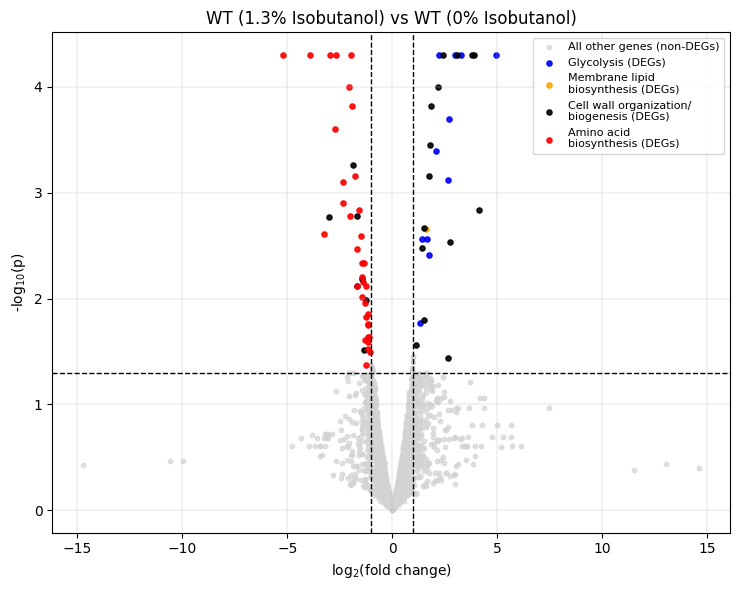

In [23]:
plotVolcano(wt_iso_vs_wt_0_annot, "WT (1.3% Isobutanol) vs WT (0% Isobutanol)")

Total (status OK) genes: 3136
Paper-DEGs: 218
Colored DEGs in categories: 54


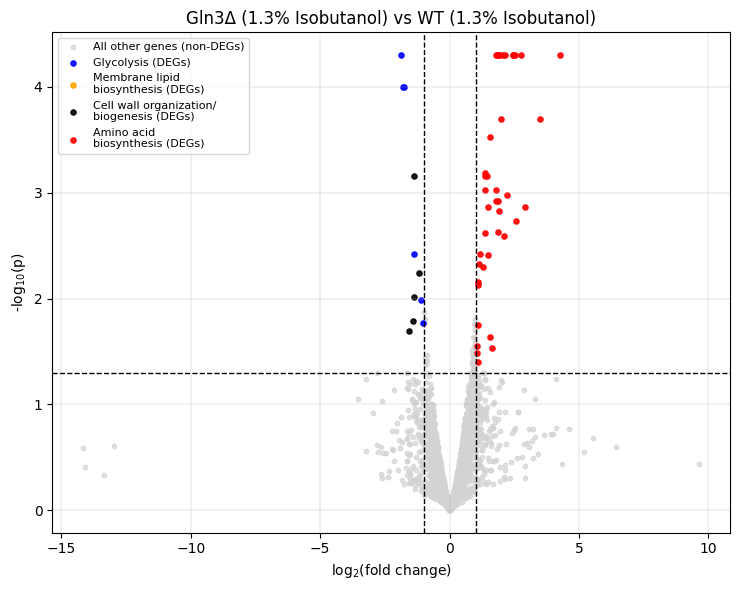

In [24]:
plotVolcano(gln3_iso_vs_wt_iso_annot, "Gln3\u0394 (1.3% Isobutanol) vs WT (1.3% Isobutanol)")